# Import libraries

In [275]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.feature_selection import SelectKBest, chi2

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Load the dataset

In [276]:
data = pd.read_csv('https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv', header=0)
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Explore the data

## 1. Explore the income distribution using stratified sampling

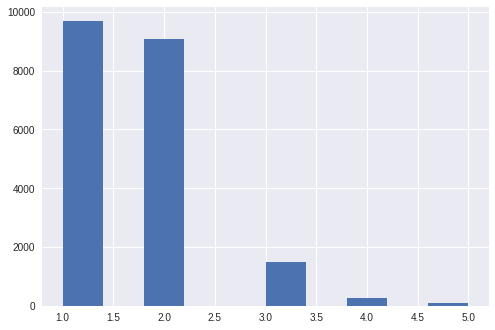

In [277]:
pd.cut(data['median_income'], bins=5, labels=[1,2,3,4,5]).hist()
plt.show()

## Plot the histogram with predifined stratums

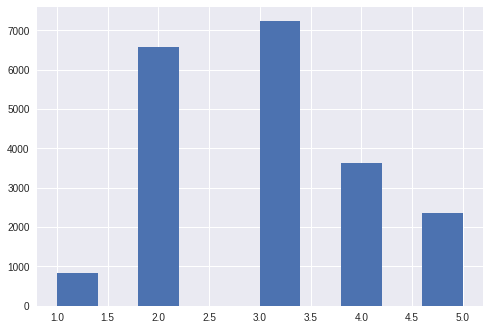

In [278]:
pd.cut(data['median_income'], bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
      labels=[1,2,3,4,5]).hist()
plt.show()

## 3. Visualize and gain insight
* So for example if we want to plot a scatter plot that represents to geographical information of the dataset (longtitude and latitude). However, this way we will only have a scatter of coordinates.

* If we want to know how the population distributes geographically, we can do so by making the scatter dot's width proportionate with the population size. Hence, we use the parameter s = data['population']/100.

* We also want the scatter plot to reflect the house price. So we want the color of the scatter dot's to vary according to housing price as well. Therefore we specify c='median_house_value' or c=data['median_house_value']

* You can specify whatever value on parameter 's' (for scatter size) and 'c' (for coloring). For example, you can also choose colormap to reflect median income. However, choose wisely in order not to misinterpret the information.

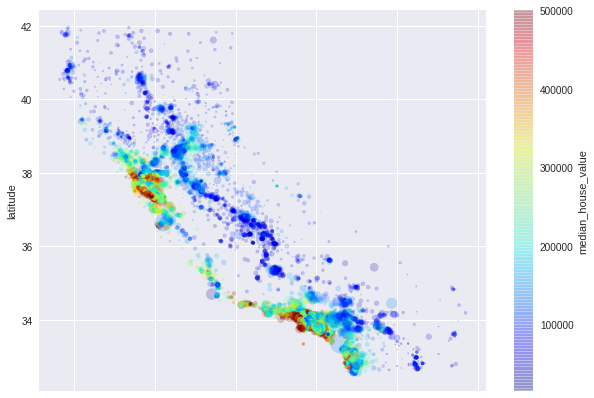

In [280]:
plt.style.use('seaborn')

data.plot(kind='scatter', x='longitude', y='latitude', alpha=0.2,
         colorbar=True,
         s = data['population']/100, # specifies the width values of the scatter dots
         c = 'median_house_value', # specifies the color map values of the scatter dots
         cmap=plt.get_cmap('jet'),
         figsize=(10, 7))
plt.show()

## 4. Attribute correlation
### 4.1. Scatter matrix

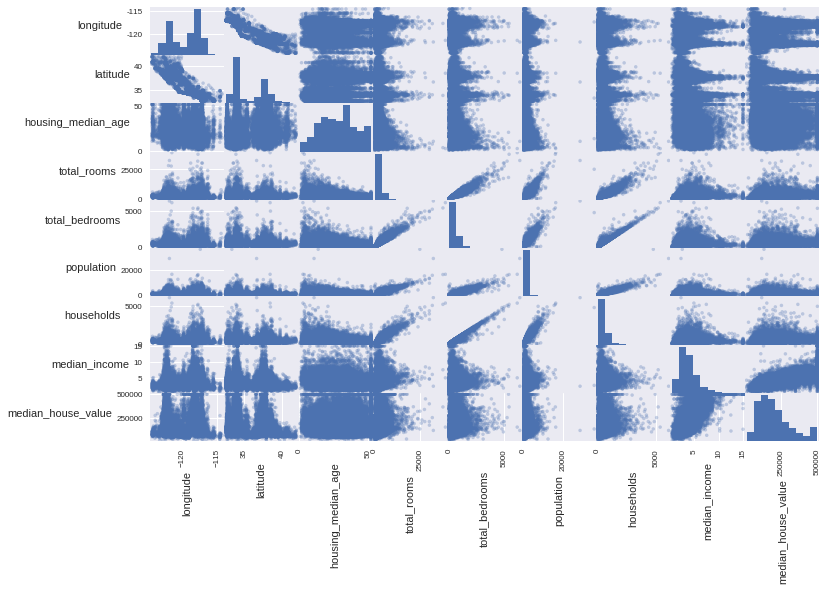

In [281]:
axes = pd.plotting.scatter_matrix(data, figsize=(12,8), alpha=0.3)

for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
    
plt.show()

### 4.2. Correlation matrix

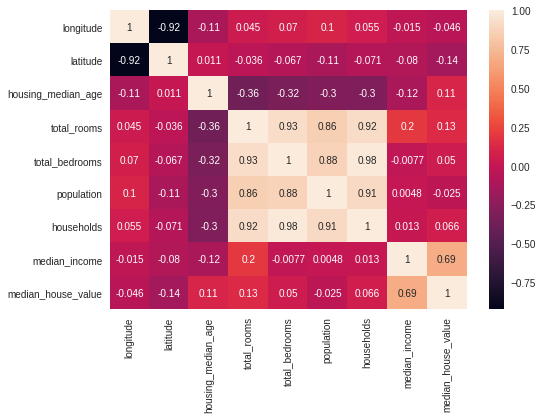

In [282]:
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

# 6. What are the top attributes that correlate to median housing value?

In [283]:
abs_corr_matrix = abs(data.corr())
abs_corr_matrix.sort_values('median_house_value')['median_house_value']

population            0.024650
longitude             0.045967
total_bedrooms        0.049686
households            0.065843
housing_median_age    0.105623
total_rooms           0.134153
latitude              0.144160
median_income         0.688075
median_house_value    1.000000
Name: median_house_value, dtype: float64

# Prepare data for regression analysis

## 1. Data Cleaning
### Handling missing values (2 options)
* Imputation or missing values handling can be done in several ways but two of the most commonly used are :
    - 1. Getting rid of all the rows with missing values (We have learned this one with dropna)
    - 2. Replacing the values with some specific values (mean, median, zero, ...)
   
* To perform the second option, we can use the SimpleImputer from sklearn. However, this class only works with numeric valued columns.

In [284]:
print('Total number of rows : ', len(data))
data.info()

Total number of rows :  20640
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [285]:
# Simple imputer in sklearn to replace missing values with median
imputer = SimpleImputer(strategy='median')
total_bedrooms = data['total_bedrooms'].values.reshape(-1, 1)
imputer.fit(total_bedrooms)

data['total_bedrooms'] = imputer.transform(total_bedrooms)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


### Handling non-numeric values
* There are several ways to handle non-numeric values 
    1. Ordinal value encoding
    2. One-hot encoding
    
* For simplicity, we will go with Ordinal encoding but I'll show you how both works

#### a. OrdinalEncoder
* Basically assign numbers to categorical data. For example blue -> 0, red -> 1

In [286]:
data_copy = data.copy()
ordinal_encoder = OrdinalEncoder()

ocean_proximity = data_copy['ocean_proximity'].values.reshape(-1, 1)
data_copy['ocean_proximity'] = ordinal_encoder.fit_transform(ocean_proximity)

data_copy.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,3.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,3.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,3.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,3.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,3.0


#### b. OneHotEncoder

In [287]:
# Create a dataframe of ocean proximity in one-hot encoded values
one_hot_encoder = OneHotEncoder()
ocean_proximity = data['ocean_proximity'].values.reshape(-1, 1)

one_hot_encoder.fit(ocean_proximity)
one_hot_vals = one_hot_encoder.transform(ocean_proximity).toarray()
categories = one_hot_encoder.categories_[0]

ocean_df = pd.DataFrame(data=one_hot_vals, columns=categories)
ocean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   <1H OCEAN   20640 non-null  float64
 1   INLAND      20640 non-null  float64
 2   ISLAND      20640 non-null  float64
 3   NEAR BAY    20640 non-null  float64
 4   NEAR OCEAN  20640 non-null  float64
dtypes: float64(5)
memory usage: 806.4 KB


In [288]:
# Concatenate this ocean df to the original dataframe 
# And drop the old ocean column
data = pd.concat([data, ocean_df], axis=1)
data.drop('ocean_proximity', axis=1, inplace=True)
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0.0,0.0,0.0,1.0,0.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0.0,0.0,0.0,1.0,0.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0.0,0.0,0.0,1.0,0.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0.0,0.0,0.0,1.0,0.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0.0,0.0,0.0,1.0,0.0


## 2. Feature scaling
* Most Machine learning algorithms do not perform well with numerical attributes with very different scales. Therefore we can apply some of the following scaling methods :
    1. Min-Max scaler : scales the values in a column to range [0,1]
    2. Standard scaler (Used today) : scales the value to a gaussian distribution with fixed mean and std (Usually mean=0.0 and std=1.0)

In [289]:
house_median_age = data['housing_median_age'].values.reshape(-1,1)
std_scaler = StandardScaler()
data['housing_median_age'] = std_scaler.fit_transform(house_median_age)

Mean of housing_median_age is :  5.508083222946513e-18
Std of housing_median_age is :  1.0000242256864988


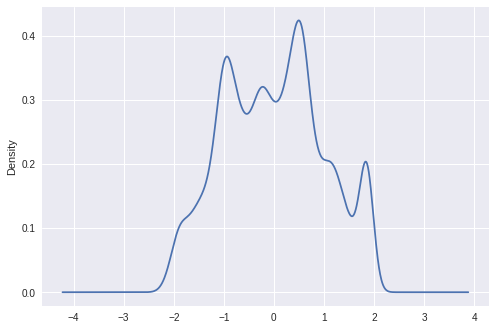

In [290]:
# As you can see after scaling the column, the distribution of the 
# housing median_age column will have an approximated mean of 0.0
# and approximated std of 1.0. So standard scaler makes 
# housing_median_age ~ N(0, 1)
print('Mean of housing_median_age is : ', data['housing_median_age'].mean())
print('Std of housing_median_age is : ', data['housing_median_age'].std())
data['housing_median_age'].plot(kind='density')
plt.show()

## 3. A fully integrated preprocessing pipeline
* Now what if we have a lot of columns to preprocess? It would be very tiring to sit down and preprocess each column one by one. Thus, we need an integrated pipeline that do the same process on every column.
* Let's recap what we just did with our data
    - 1. Deal with categorical data using OneHotEncoder
    - 2. Deal with missing values with a simple imputer (median strategy)
    - 3. Scale numeric values using standard scaler
    - 4. Concatenate preprocessed numeric and categorical columns together

* It would be a drag if we have to remember this whole process whenever we prepare the data. Luckily sklearn provide a Pipeline class that helps use do all these within a single processor

In [291]:
data = pd.read_csv('https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv', header=0)
numeric_cols = list(data.select_dtypes(['float64']).columns)
numeric_cols.remove('median_house_value') # since we don't want to include our target as features
cat_cols = ['ocean_proximity']

# Pipeline will compose a list of data processors into a sequence
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()) 
])

# Column transformer will specify what processor will be applied to 
# what columns in the dataframe and return those processed columns
full_pipeline= ColumnTransformer([
    ("num", num_pipeline, numeric_cols), # imputation and standard scaler for numeric cols
    ("cat", OrdinalEncoder(),  cat_cols) # ordinal encoding for categorical cols
])

features = full_pipeline.fit_transform(data)
features = pd.DataFrame(data=features, columns=numeric_cols + cat_cols)
targets = data['median_house_value']
features.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-1.327835,1.052548,0.982143,-0.804819,-0.972476,-0.974429,-0.977033,2.344766,3.0
1,-1.322844,1.043185,-0.607019,2.045890,1.357143,0.861439,1.669961,2.332238,3.0
2,-1.332827,1.038503,1.856182,-0.535746,-0.827024,-0.820777,-0.843637,1.782699,3.0
3,-1.337818,1.038503,1.856182,-0.624215,-0.719723,-0.766028,-0.733781,0.932968,3.0
4,-1.337818,1.038503,1.856182,-0.462404,-0.612423,-0.759847,-0.629157,-0.012881,3.0


# Regression analysis
* Predict house prices using Linear Regression and its variants

## 1. Feature selection - Chi-Square test
* The first thing we need to do before we build a model is to decide which features are the best indicators of the target value that we want to predict. We cannot select all if this table is too big.
* A common way to do this is using the chi-square test for correlation to test weather a feature is correlated with the target value.
* However, chi-square only works with numeric columns. So to test categorical data's correlation to the target, we can do so by naively encode the data into ordinal form first.
* Also, chi-square test also works with positive values only. Therefore, we have to apply MinMaxScaler for all numeric columns we have. That way all values are clipped in the range [0,1]
* Link to Chi-Square details (Explanation and example) : <a href="https://towardsdatascience.com/chi-square-test-for-feature-selection-in-machine-learning-206b1f0b8223">Link</a>

In [292]:
selected_features = []

# Select 6 best features with chi square. Also, apply MinMaxScaler
# on all of the features
selector = SelectKBest(chi2, k=6)
selector.fit_transform(MinMaxScaler().fit_transform(features), targets)

# Get support will return a boolean array corresponding to column names
# If support is 'True', the column is selected
supports = selector.get_support()

print(supports)
print(features.columns)

[ True  True  True  True False False False  True  True]
Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')


In [293]:
# Loop thru both array and pick the features selected
for support, feature in zip(supports, features.columns):
    if(support == True):
        selected_features.append(feature)
        
print('Selected features are : ', selected_features)

Selected features are :  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'median_income', 'ocean_proximity']


In [294]:
# New replace the old features with the selected ones
features = features[selected_features]
features.head()

,longitude,latitude,housing_median_age,total_rooms,median_income,ocean_proximity
0,-1.327835,1.052548,0.982143,-0.804819,2.344766,3.0
1,-1.322844,1.043185,-0.607019,2.045890,2.332238,3.0
2,-1.332827,1.038503,1.856182,-0.535746,1.782699,3.0
3,-1.337818,1.038503,1.856182,-0.624215,0.932968,3.0
4,-1.337818,1.038503,1.856182,-0.462404,-0.012881,3.0


## 2. Build regression models

### a. Train-test set split